In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pyquaternion import Quaternion
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Load the Excel file
df_ref = pd.read_excel('Filtered_PCD_Annotations_AB.xlsx')

In [3]:
def get_object_perspective(cam_pose_x, cam_pose_y, box_x, box_y, box_z, box_rotation_w, box_rotation_z):
    """
    Determines the perspective of an object relative to the camera.

    Parameters:
    - box_center: np.array([x, y, z]) → center of the box in world coordinates
    - orientation_quat: Quaternion(w, 0, 0, z) → rotation around Z-axis only
    - cam_position: np.array([x, y, z]) → camera position in world coordinates
    - threshold: angle threshold in radians for classification

    Returns:
    - One of: 'toward', 'away', 'left', 'right'
    """
    threshold=np.pi / 4

    # Camera position in global coordinates
    cam_position = np.array([cam_pose_x, cam_pose_y, 0])  # shape: (3,)

    orientation_quat = Quaternion(
        box_rotation_w,
        0.0, 0.0,
        box_rotation_z
    )
    
    # Compute forward direction of the box (local +X axis rotated by orientation)
    forward_vector = orientation_quat.rotate(np.array([1, 0, 0]))  # shape: (3,)

    # Vector from box to camera
    box_center = [box_x, box_y, box_z]
    to_camera = cam_position - box_center
    to_camera = to_camera / np.linalg.norm(to_camera)

    # Compute angle between forward direction and camera vector
    dot = np.dot(forward_vector[:2], to_camera[:2])  # only XY plane
    angle = np.arccos(np.clip(dot, -1.0, 1.0))  # radians

    # Pad vectors to 3D by adding a zero Z-component
    forward_xy = np.array([forward_vector[0], forward_vector[1], 0])
    to_camera_xy = np.array([to_camera[0], to_camera[1], 0])
    
    # Compute cross product and extract Z-component
    cross_z = np.cross(forward_xy, to_camera_xy)[2]


    # Classify based on angle and cross product
    if angle < threshold:
        return 0 #'toward'
    elif angle > (np.pi - threshold):
        return 1 #'away'
    elif cross_z > 0:
        return 2 #'left'
    else:
        return 3 #'right'

In [4]:
# Load the Excel file

df = df_ref.copy()

selected_columns = [
    'a_camera_pose_x', 'a_camera_pose_y', 'a_camera_pose_z', 
    'b_camera_pose_x', 'b_camera_pose_y', 'b_camera_pose_z', 
    'a_center_x', 'a_center_y', 'a_center_z', 
    'b_center_x', 'b_center_y', 'b_center_z', 
    'a_length', 'a_width', 'a_height', 
    'b_length', 'b_width', 'b_height', 
    'a_rotation_w', 'a_rotation_x', 'a_rotation_y', 'a_rotation_z', 
    'b_rotation_w', 'b_rotation_x', 'b_rotation_y', 'b_rotation_z', 
    'a_yaw', 
    'b_yaw',
    'a_category',
    'b_category', 
    'a_brake', 'a_brake_switch', 'a_rear_left_rpm', 'a_rear_right_rpm', 'a_vehicle_speed', 'a_yaw_rate',
    'b_brake', 'b_brake_switch', 'b_rear_left_rpm', 'b_rear_right_rpm', 'b_vehicle_speed', 'b_yaw_rate',
    'a_distance', 
    'b_distance', 
    'a_vx', 'a_vy',             
    'b_vx', 'b_vy']
    


df = df[selected_columns]


# Encode box1_category_name
le_category = LabelEncoder()
df['a_category_encoded'] = le_category.fit_transform(df['a_category'])


df['a_box_perspective'] = df.apply(
    lambda row: get_object_perspective(
        row['a_camera_pose_x'],
        row['a_camera_pose_y'],
        row['a_center_x'],
        row['a_center_y'],
        row['a_center_z'],
        row['a_rotation_w'],
        row['a_rotation_z']
    ),
    axis=1
)

df_cleaned_data = df.copy()

df_cleaned_data = df_cleaned_data.drop_duplicates()

# Translation deltas
df_cleaned_data['delta_center_x'] = df_cleaned_data['b_center_x'] - df_cleaned_data['a_center_x']
df_cleaned_data['delta_center_y'] = df_cleaned_data['b_center_y'] - df_cleaned_data['a_center_y']
df_cleaned_data['delta_center_z'] = df_cleaned_data['b_center_z'] - df_cleaned_data['a_center_z']

df_cleaned_data['delta_length'] = df_cleaned_data['b_length'] - df_cleaned_data['a_length']
df_cleaned_data['delta_width'] = df_cleaned_data['b_width'] - df_cleaned_data['a_width']
df_cleaned_data['delta_height'] = df_cleaned_data['b_height'] - df_cleaned_data['a_height']


df_cleaned_data['delta_vehicle_speed'] = df_cleaned_data['b_vehicle_speed'] - df_cleaned_data['a_vehicle_speed']

def compute_delta_quaternion(row):
    q1 = Quaternion([row['a_rotation_w'], 0.0, 0.0, row['a_rotation_z']])
    q2 = Quaternion([row['b_rotation_w'], 0.0, 0.0, row['b_rotation_z']])
    delta_q = q2 * q1.inverse
    return pd.Series({'delta_rotation_w': delta_q.w, 'delta_rotation_x': delta_q.x, 'delta_rotation_y': delta_q.y,'delta_rotation_z': delta_q.z})

df_quat_delta = df_cleaned_data.apply(compute_delta_quaternion, axis=1)
df_cleaned_data = pd.concat([df_cleaned_data, df_quat_delta], axis=1)

# Remove columns with only one unique value
df_cleaned_data = df_cleaned_data.loc[:, df_cleaned_data.nunique() > 1]


df_cleaned_data['a_category_encoded'] = df_cleaned_data['a_category_encoded'].astype('category')

df_cleaned_data = df_cleaned_data.drop(['a_category', 'b_category'], axis=1)

# Select numeric features
non_numeric_cols = df_cleaned_data.select_dtypes(exclude='number').columns.tolist()
df_cleaned_data = pd.get_dummies(df_cleaned_data, columns=non_numeric_cols, drop_first=True)

df_cleaned_data.shape

(5376, 62)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Select numeric features
numeric_df = df_cleaned_data.select_dtypes(include='number')

numeric_df = numeric_df.drop(['a_vx', 'a_vy', 'b_vx', 'b_vy'], axis=1)  

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

pca = PCA(n_components=min(10, X_scaled.shape[1]))  # You can adjust n_components
X_pca = pca.fit_transform(X_scaled)
y1 = df_cleaned_data['a_vx']
y2 = df_cleaned_data['a_vy']


X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    X_pca, y1, y2, test_size=0.2, random_state=42
)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    model.fit(X_train, y1_train)
    y1_pred = model.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y1_test, y1_pred)),
        'MAE': mean_absolute_error(y1_test, y1_pred),
        'R2': r2_score(y1_test, y1_pred)
    }

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train, y1_train, epochs=100, batch_size=32, verbose=0)

y1_pred_nn = nn_model.predict(X_test).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y1_test, y1_pred_nn)),
    'MAE': mean_absolute_error(y1_test, y1_pred_nn),
    'R2': r2_score(y1_test, y1_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


                      RMSE       MAE        R2
LinearRegression  2.934509  1.894695  0.445757
RandomForest      1.372563  0.486958  0.878747
GradientBoosting  1.863451  0.992471  0.776506
SVR               2.127152  0.927331  0.708777
NeuralNet         1.563113  0.859501  0.842743


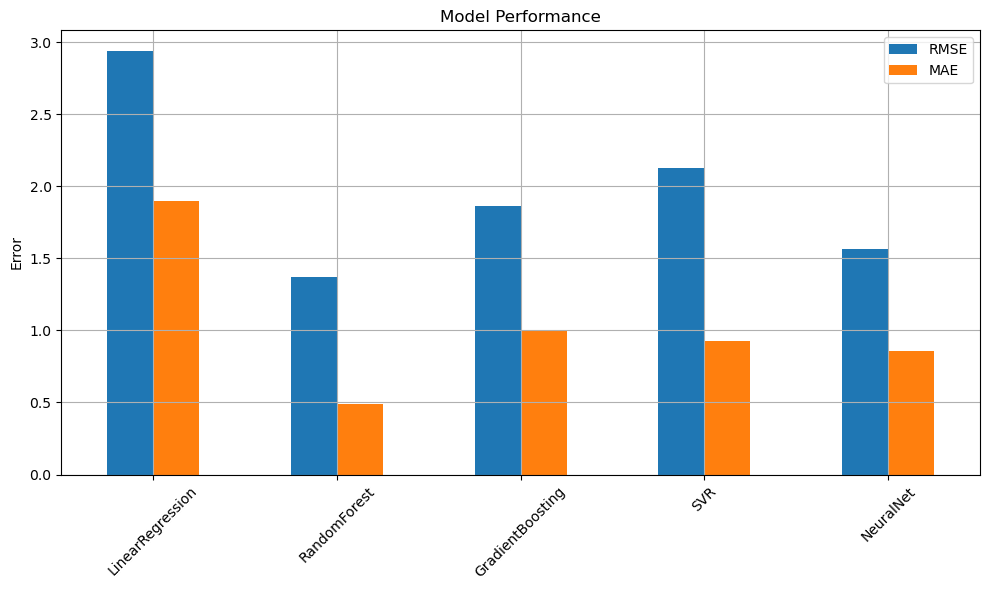

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
print(results_df)

results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Performance')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200


c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11.2388 - mae: 2.3830 - val_loss: 5.6392 - val_mae: 1.5586 - learning_rate: 0.0100
Epoch 2/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0868 - mae: 1.8088 - val_loss: 5.3044 - val_mae: 1.4242 - learning_rate: 0.0100
Epoch 3/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5998 - mae: 1.7626 - val_loss: 4.4002 - val_mae: 1.2475 - learning_rate: 0.0100
Epoch 4/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8516 - mae: 1.6215 - val_loss: 4.8107 - val_mae: 1.4599 - learning_rate: 0.0100
Epoch 5/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6115 - mae: 1.5747 - val_loss: 4.2087 - val_mae: 1.2533 - learning_rate: 0.0100
Epoch 6/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5812 - mae: 1.5513 - val_loss: 3.9880 - val_mae: 1.1571 - learning_rate: 0.0100
Epoch 7/200
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2114 - mae: 1.5063 - val_loss: 3.7516 - val_mae: 1.1808 - learning_rate: 0.0100
Epoch 8/20

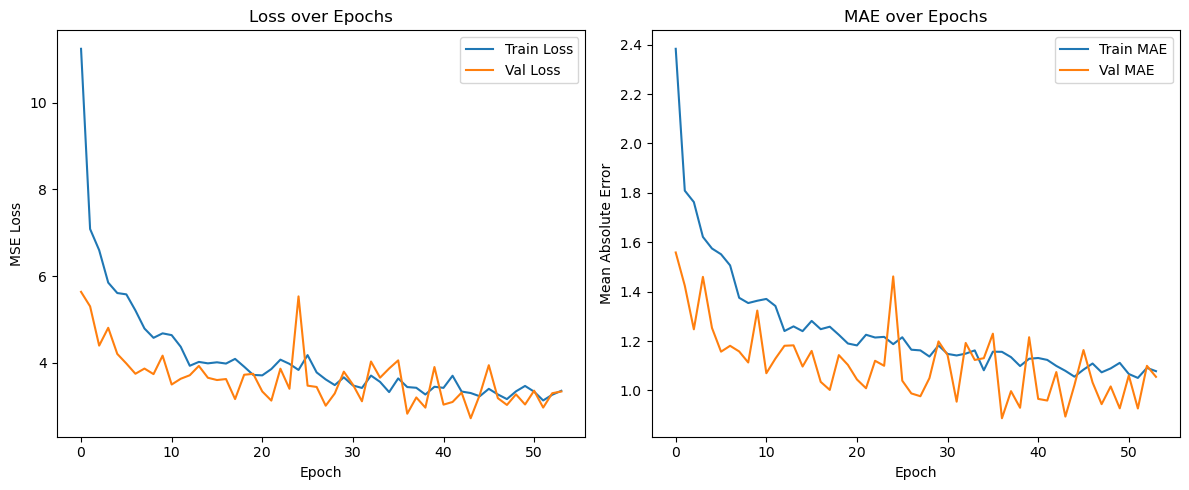

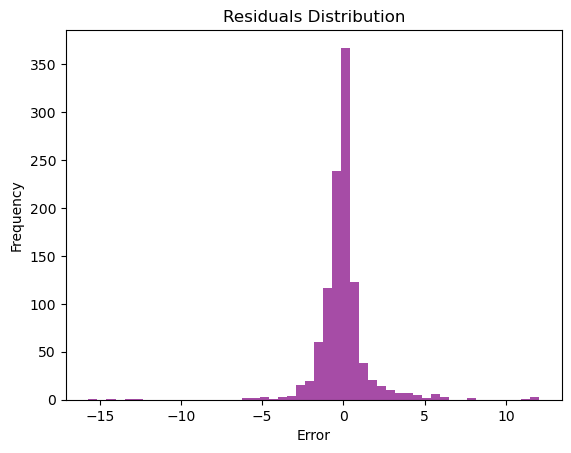

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Define model architecture
def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(0.001), input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    return model

# Compile model
nn_model = build_nn_model(X_train.shape[1])
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# Train model
history = nn_model.fit(
    X_train, y1_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# Predict and evaluate
y1_pred_nn = nn_model.predict(X_test).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y1_test, y1_pred_nn)),
    'MAE': mean_absolute_error(y1_test, y1_pred_nn),
    'R2': r2_score(y1_test, y1_pred_nn)
}

# Print results
for metric, value in results['NeuralNet'].items():
    print(f"{metric}: {value:.4f}")

# Plot training loss and MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Plot residuals
residuals = y1_test - y1_pred_nn
plt.hist(residuals, bins=50, color='purple', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

🔍 Random Forest Performance:
RMSE: 1.3691
MAE: 0.5050
R2: 0.8794


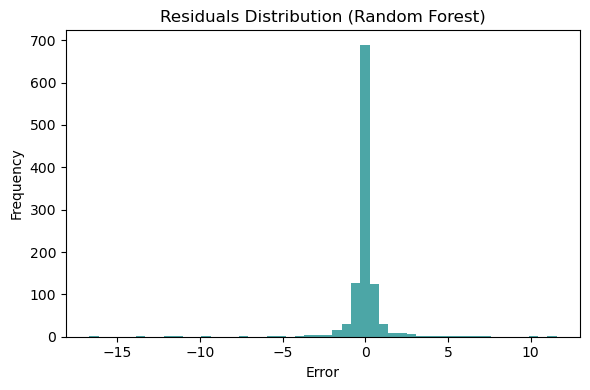

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Step 1: Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y1_train)

best_rf = grid_search.best_estimator_

# Step 2: Predict and evaluate
y1_pred_rf = best_rf.predict(X_test)
results['RandomForest_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(y1_test, y1_pred_rf)),
    'MAE': mean_absolute_error(y1_test, y1_pred_rf),
    'R2': r2_score(y1_test, y1_pred_rf)
}

# Print results
print("🔍 Random Forest Performance:")
for metric, value in results['RandomForest_Tuned'].items():
    print(f"{metric}: {value:.4f}")

# Step 3: Residual analysis
residuals = y1_test - y1_pred_rf
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, color='teal', alpha=0.7)
plt.title("Residuals Distribution (Random Forest)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

results = {}

for name, model in models.items():
    model.fit(X_train, y2_train)
    y2_pred = model.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y2_test, y2_pred)),
        'MAE': mean_absolute_error(y2_test, y2_pred),
        'R2': r2_score(y2_test, y2_pred)
    }

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

nn_model.fit(X_train, y2_train, epochs=100, batch_size=32, verbose=0)

y2_pred_nn = nn_model.predict(X_test).flatten()
results['NeuralNet'] = {
    'RMSE': np.sqrt(mean_squared_error(y2_test, y2_pred_nn)),
    'MAE': mean_absolute_error(y2_test, y2_pred_nn),
    'R2': r2_score(y2_test, y2_pred_nn)
}

c:\Users\dilip\anaconda3\envs\radarviz\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


                      RMSE       MAE        R2
LinearRegression  1.242111  0.900940  0.764648
RandomForest      0.455186  0.194414  0.968394
GradientBoosting  0.660904  0.392130  0.933369
SVR               0.801369  0.378509  0.902037
NeuralNet         0.506522  0.255892  0.960862


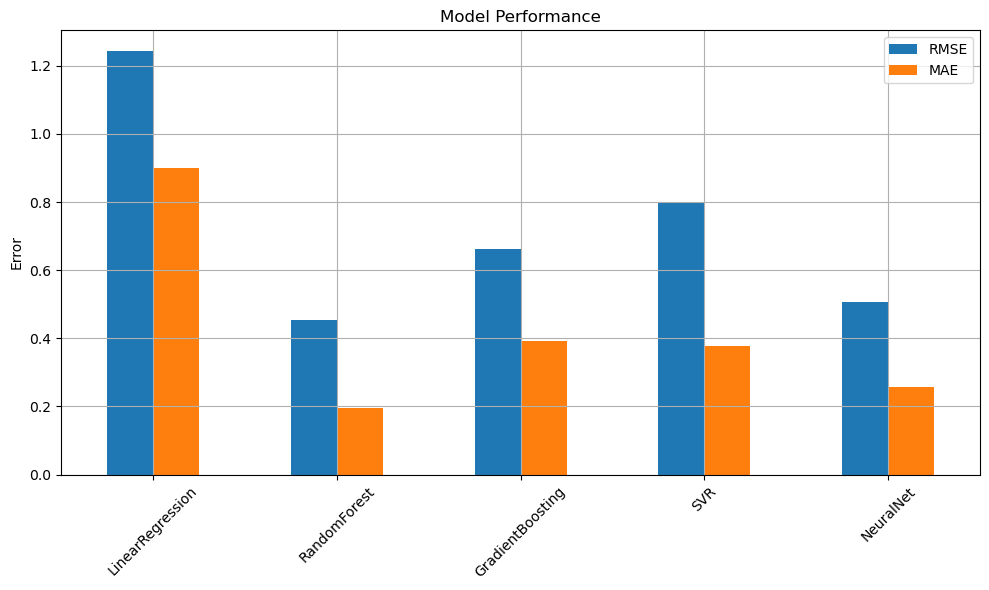

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
print(results_df)

results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), title='Model Performance')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()